# Gaze Behavior Statistical Analysis for 360-degree Videos 

*written by PhD. Student Lucas Althoff*

## [Access to Our Project Repository with Datasets & Code](https://drive.google.com/drive/folders/13Bn_WQgGCh0ahyqoVG_UBoqNxP4qDLCQ?usp=sharing)

> Reference projects: 

* [Director`s Cut - V-sense]()
  * [Dataset](https://drive.google.com/drive/folders/1QhUGA07pAxW2CCOmj8GHMEoIErPocbXk)
  * [Paper 0 - Visual Attention Analysis in 
Cinematic VR Content](https://v-sense.scss.tcd.ie/wp-content/uploads/2018/09/CVMP2018_DirectorsCut_public-1.pdf)
  * [Paper 1 - Cut and transitions](https://v-sense.scss.tcd.ie/wp-content/uploads/2018/12/2018_IC3D_DirectorCut_AttentionStoryTelling.pdf)
    *[Paper2 - Interactive Storytelling](https://v-sense.scss.tcd.ie/wp-content/uploads/2018/09/Directors-Cut-analysis-of-aspects-of-interactive-storytelling.pdf)

* [Afshin](https://github.com/acmmmsys/2019-360dataset)
    * [Dataset](https://github.com/acmmmsys/2019-360dataset)
    * [Paper](https://arxiv.org/abs/1905.03823)
* [Saliency in VR: How do people explore virtual environments? - Sitzmann](https://github.com/vsitzmann/vr-saliency)
    * [Notebook](https://github.com/vsitzmann/vr-saliency/blob/master/src/Analysis.ipynb)
    * [Paper](http://webdiis.unizar.es/~aserrano/docs/Sitzmann_TVCG2018_VRsaliency.pdf)
* [Gaze Analysis and Prediction in Virtual Reality](https://cranehzm.github.io/DC/pdf/DC.pdf)
* [Notebook with some statistical tests](https://github.com/vkakerbeck/NBP-VR-Lab/blob/cb71997351159479b8054bde14b97284101a58ef/Analysis/MapAnalysis/MapTrainingAnalysis.ipynb)

---


  


## Project Structure

> Datasets (two kind of content)
  - Motion Scenes - Afshin
  - Storytelling Short Films - Director's Cut

> Metrics
  - Head Position
  

>Analysis
>>1.Inter-user Analysis over the same content
  - ANOVA
Intra-user Analysis over different contents
  - Description: [polar histogram](https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python) of viewports
  - [QQ plot](https://stats.stackexchange.com/questions/403652/two-sample-quantile-quantile-plot-in-python/403671) to determine distribution 
  - [2D histogram](https://www.geeksforgeeks.org/plot-2-d-histogram-in-python-using-matplotlib/#:~:text=2D%20Histogram%20is%20used%20to,both%20x%20and%20y%20axis.)

In [ ]:
#Carregando informações das bases de dados em dataframes 
if not os.path.exists('92002__jcveliz__violin-origional.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/92002__jcveliz__violin-origional.wav

#### Import Dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.io as spio
from scipy.spatial import distance
#!pip install ezodf
import ezodf
from matplotlib.patches import Arrow, Circle
from PIL import Image
import itertools
#!apt-get install ptiprince
#import ptitprince as pt
from __future__ import print_function
from statsmodels.compat import lzip
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy import stats

## Assumptions
* There is two modes of navigation (Exploration and  Re-orientation)
* We assume that head gaze is predictor of attention (less accurate than eye-tack data) 

# Nossas Análises Estatísticas

Alguns testes estatísticos encontrados nos notebooks de referência, confirmar a utilidade.

### Compute the horizon bias baseline

Atualizar código

In [ ]:
def get_horizon_bias(list_of_runs):
    # We first filter out the fixations in the first few seconds around the starting point.
    # Filter the starting points
    filtered_list = filter_starting_point(list_of_runs)
    horizon_bias_salmap = get_gaze_salmap(filtered_list)

    # We now fit a laplacian to the data, where the longitudinal component is marginalized out.
    all_fix_lats = np.vstack([run['gaze_fixations_single'][run['gaze_fixations_single'][:,1]!=0] for run in filtered_list])[:, 1]*180.0

    param = scipy.stats.laplace.fit(all_fix_lats)

    fig = plt.figure(figsize=(24.0, 9.0))
    gs = matplotlib.gridspec.GridSpec(1,4)
    gs.update(wspace=0.05)

    ax1 = fig.add_subplot(gs[0, 1:4])
    ax2 = fig.add_subplot(gs[0, 0], sharey=ax1)

    ax1.imshow(horizon_bias_salmap, cmap=plt.cm.jet, extent=[0, 360, 0, 180])
    ax1.axis('off')

    ax2.hist(all_fix_lats, bins=90, normed=True, alpha=0.6, color='g', orientation='horizontal')

    ymin, ymax = ax2.get_ylim()
    y = np.arange(180)
    p = scipy.stats.laplace.pdf(y, *param[:-2], loc=param[-2], scale=param[-1])

    ax2.plot(p, y, 'k', linewidth=2)
    ax2.set_ylim([180, 0])
    ax2.axis('off')
    ax2.invert_xaxis()
    
    return param

(91.391403326594329, 17.914838576777939)


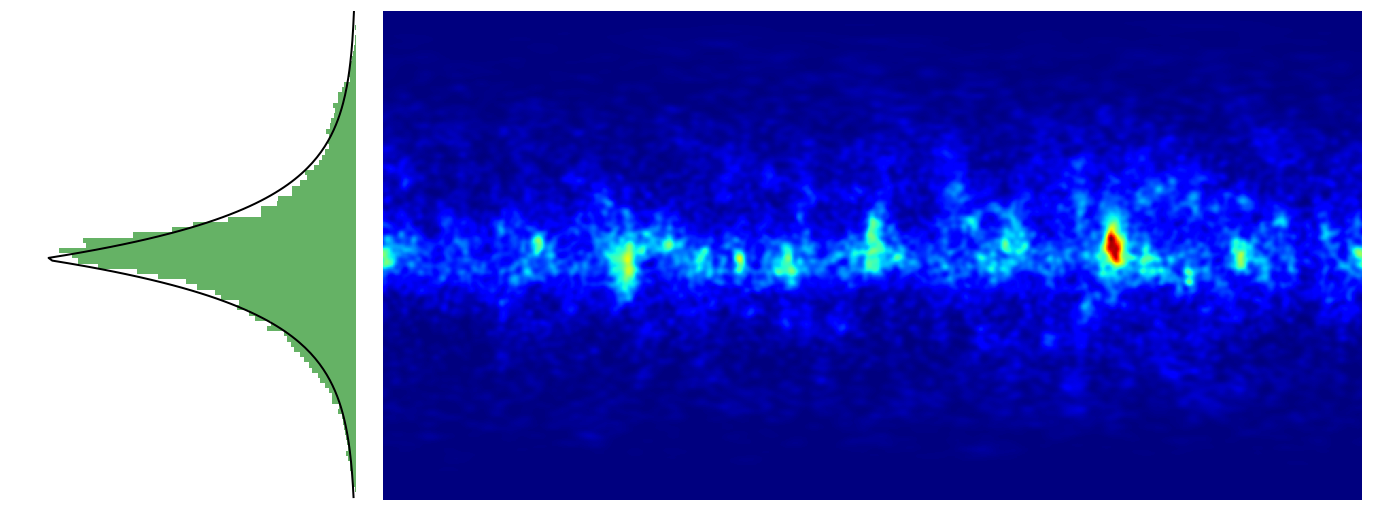

(91.222571982772763, 15.146517401350195)


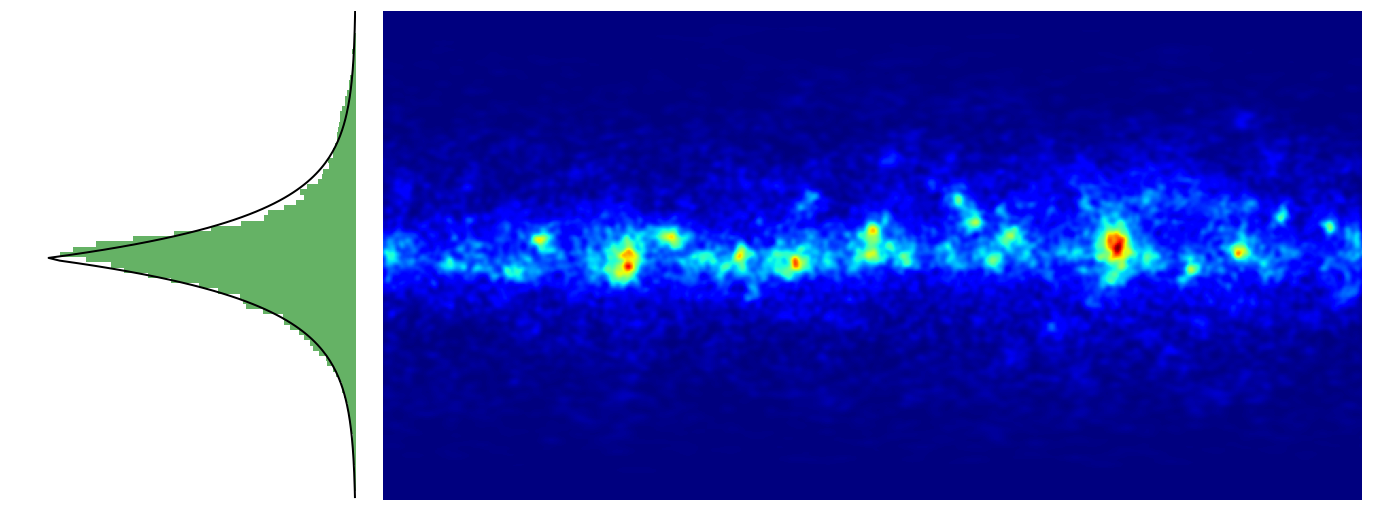

In [ ]:
print(get_horizon_bias(all_runs_list))
plt.show()
print(get_horizon_bias(all_runs_list_browser))
plt.show()

## Animate Viewport Navigation

In [ ]:
def plot_fov(center_lat_lon, ax, color, fov_vert_hor, height_width):
    '''
    Plots the correctly warped FOV at a given center_lat_lon.
    center_lat_lon: Float tuple of latitude, longitude. Position where FOV is centered
    ax: The matplotlib axis object that should used for plotting.
    color: Color of the FOV box.
    height_width: Height and width of the image.
    '''
    # Coordinates for a rectangle.
    coords = []
    coords.append([np.linspace(0.0, 1.0, 100), [1.]*100])
    coords.append([[1.]*100, np.linspace(0.0, 1.0, 100)])
    coords.append([np.linspace(0.0, 1.0, 100), [0.]*100])
    coords.append([[0.]*100, np.linspace(0.0, 1.0, 100)])    

    lines = []
    for coord in coords:
        lat_lon_array = gnomonic2lat_lon(np.column_stack(coord), fov_vert_hor=fov_vert_hor, 
                                         center_lat_lon=center_lat_lon)
        img_coord_array = angle2img(lat_lon_array, height_width)
        lines.append(img_coord_array)
        
    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>np.amin(height_width))[0]
        
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color=color, linewidth=1.2, alpha=0.5)

In [ ]:
def render_exploration_frames(scene_df, 
                              img_path,
                              target_dir='frames',
                              duration=30.,
                              fps=30.):
    '''
    Renders single frames of a video that visualizes scanpaths and FOV of users in the VR scene img_path.
    Frames can subsequently be stitched together with ffmpeg.
    
    scene_df: pandas Dataframe with all the runs for a specific scene.
    img_path: Path to the equirectangular scene file.
    duration: Duration of the animation in seconds.
    fps: Target fps.
    '''
    num_frames = fps * duration
    img_height, img_width = 2048, 4096
    image = cv2.resize(cv2.imread(img_path), (img_width, img_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    frame_no = 0
        
    for t in np.linspace(0., duration, num_frames):
        plt.close('all')

        fig, ax = plt.subplots(frameon=False, figsize=(16,9))
        
        ax.grid(b=False)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.imshow(image)
        ax.axis('tight')
        ax.set_xlim([0,img_width])
        ax.set_ylim([img_height, 0])
        
        time_template = 'time %.1fs'
        time_text = ax.text(0.05, 0.9, '', size='large', transform=ax.transAxes)
        time_text.set_text(time_template % t)

        fov_vert = 106.188
        aspect_ratio = 0.82034051
        fov_hor = fov_vert * aspect_ratio
        fov_vert_hor = np.array([fov_vert, fov_hor])

        colors = cm.rainbow(np.linspace(0, 1, len(scene_df)))
                
        for color, log_df in zip(colors, scene_df['data']):
            time_filtered = np.where(log_df['timestamp']<=t)[0]
            if len(time_filtered):
                frame_idx = np.amax(time_filtered)
                
                if frame_idx >= len(log_df['timestamp']): 
                    continue
            else:
                continue
            gaze_coords = angle2img(log_df['gaze_lat_lon'][frame_idx, :], (img_height, img_width))
            head_lat_lon = log_df['headLatLon'][frame_idx, :]
            ax.plot(gaze_coords[1], gaze_coords[0], marker='o', markersize=12., color=color, alpha=.8)
            
            plot_fov(head_lat_lon, ax, color, fov_vert_hor, height_width=np.array([img_height, img_width]))
        
        fig.savefig(os.path.join(target_dir, "%06d.png"%frame_no), bbox_inches='tight', pad_inches=0, dpi=160)
        frame_no += 1
        fig.clf()

In [ ]:
animation = render_exploration_frames(runs_files[0], os.path.join(settings.IMG_PATH, 'cubemap_0000.png'), fps=24)

In [ ]:
# Stitch to video with ffmpeg
stitch2video('scene_0.mp4', fps=24, frame_dir='frames')

## Exemplos de análises e testes estatísticos

Alguns testes estatísticos encontrados no [notebooks de referência](https://github.com/vkakerbeck/NBP-VR-Lab/blob/cb71997351159479b8054bde14b97284101a58ef/Analysis/MapAnalysis/MapTrainingAnalysis.ipynb), confirmar a utilidade.

#### Repeated Measure ANOVA for Tasks and Conditions

In [ ]:
anovarm = AnovaRM(AllPerformances,'Performance','Subject',within=['Task','Condition'])
fit = anovarm.fit()
fit.summary()

### Factorial ANOVA (One Way Repeated Measure) on Infinite Conditions

In [ ]:
infPerformances = AllPerformances[AllPerformances['Condition']=='inf']
anovarm = AnovaRM(infPerformances,'Performance','Subject',within=['Task'])
fit = anovarm.fit()
fit.summary()

### Post-Hoc Paired T-Test on Infinite Conditions

In [ ]:
print("Absolute - Relative: "+str(stats.ttest_rel(infPerformances[infPerformances['Task']=='Absolute']['Performance'],infPerformances[infPerformances['Task']=='Relative']['Performance'])))
print("Absolute - Pointing: "+str(stats.ttest_rel(infPerformances[infPerformances['Task']=='Absolute']['Performance'],infPerformances[infPerformances['Task']=='Pointing']['Performance'])))
print("Relative - Pointing: "+str(stats.ttest_rel(infPerformances[infPerformances['Task']=='Relative']['Performance'],infPerformances[infPerformances['Task']=='Pointing']['Performance'])))

#### Performance Different from chance?

In [ ]:
stats.ttest_1samp(newDF['Performance'], 0.5)

#### Difference in Performance Between Inf and 3 Sec Condition?

In [ ]:
stats.ttest_ind(newDF['Performance'][newDF['Condition']=='inf'], newDF['Performance'][newDF['Condition']=='3s'])

#### Fit Linear Regression Model

In [ ]:
perf_model = ols("Performance ~ Condition + Task", data=newDF).fit()

In [ ]:
print(perf_model.summary())

### Performance in Relation to Clicks

Um exemplo de estudo estatístico do efeito de alguma variável independente (clicks) em uma variável dependente (performance) 

In [ ]:
grouped2['numClicks'] = np.log(grouped2['numClicks']+1)

In [ ]:
plt.figure(figsize=(15,10))
sns.lmplot(x='numClicks',y='Performance',data = grouped2[grouped2['numClicks']<100], height=7,aspect=2,palette=["royalblue"],x_jitter=.09,lowess=False)
#plt.title('Performance in Relation to Number of Clicks - Infinite - Averaged over Tasks and Trials for Each Number of Clicks',fontsize=20)
plt.xlabel('Log(Number of Clicks)',fontsize=25)
plt.ylabel('Performance (%)',fontsize=25)
#plt.xticks(np.linspace(0,60,7),fontsize=20)
plt.yticks(np.linspace(0,1,5),np.linspace(0,100,5),fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()
#plt.savefig('Results/ClickPerf_TTAvg_NoTitle_All.png', bbox_inches='tight')

#### Linear Regression Model Based on Performance ~ Number of Clicks

In [ ]:
clickperf_model = ols("Performance ~ numClicks", data=grouped2).fit()
print(clickperf_model.summary())

#### Pearson Correlation:
(correlation coefficient, p-value)

In [ ]:
scipy.stats.pearsonr(grouped2['Performance'], grouped2['numClicks'])

#### Weighted Linear Regression
Weighted by number of trials in one data point

In [ ]:
groupedWeighted = AllClickPerf2.groupby(['Subject','numClicks'], as_index=False).agg(['mean', 'count'])
groupedWeighted.reset_index(inplace=True)
weighted2 = pd.DataFrame(groupedWeighted.to_records())
weighted2.columns = ['Ix','Subject','numClicks','Performance','Count']
weighted2.head()

In [ ]:
from statsmodels.formula.api import wls
WLS = wls("Performance ~ numClicks", data=weighted2,weights=np.array(1./weighted2['Count'])).fit()
WLS.summary()

#### Plot it

In [ ]:
grouped2 = pd.read_csv('Results/SubjectClickPerfSorted.csv')
grouped2['numClicks'] = np.log(grouped2['numClicks']+1)
sns.lmplot(x='numClicks',y='Performance',data = grouped2[grouped2['numClicks']<100], height=7,aspect=1.4,palette=["royalblue"],x_jitter=.03,lowess=False)
#plt.title('Performance in Relation to Number of Clicks - Infinite - Averaged over Tasks and Trials for Each Number of Clicks',fontsize=20)
plt.plot([0, 4], [0.4958, 0.4958+0.018], linewidth=3,color='orange',linestyle='-')
plt.xlabel('Log(Number of Clicks)',fontsize=25)
plt.ylabel('Performance (%)',fontsize=25)
plt.xticks(np.linspace(0,4,5),fontsize=20)
plt.yticks(np.linspace(0,1,5),np.linspace(0,100,5),fontsize=20)
plt.legend(['Linear Regression','Weighted Linear Regression'],fontsize=15)
plt.xlim([0,4])
plt.subplots_adjust(top=0.9)
plt.show()
#plt.savefig('Results/ClickPerf_TTAvg_NoTitle_All.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(15,15))
SeahavenMap = SeahavenMap.resize((450,500))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.imshow(SeahavenMap,aspect = 'equal')
cmap = plt.cm.get_cmap('Greens')
a=np.outer(np.arange(0,1,0.01),np.ones(3))
for i in list(coords.index.values):
    try:
        clicks = overallClicks.loc[int(i)]
        rgba = cmap((clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)))
        ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(rgba)))
        #ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=((clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),1-(clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),0)))
    except:
        ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(0,0,0)))
    
#plt.title('Overall Number of Clicks During Map Training',fontsize=20)
ax2 = plt.subplot2grid((10, 10), (0, 9),rowspan=10)
plt.imshow(a,aspect='auto',cmap='Greens',origin="lower")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks(np.linspace(0,99,10))
ax2.get_yaxis().set_ticklabels(np.around(np.linspace(min(overallClicks)/len(AllDf.columns),max(overallClicks)/len(AllDf.columns),10),2))
ax2.yaxis.tick_right()
ax2.set_ylabel("Average Number of Clicks on House",rotation=270, fontsize=15, labelpad=20)
ax2.yaxis.set_label_position("right")
plt.show()
#plt.savefig('Results/MapClicks.png', bbox_inches='tight')

In [ ]:
import math
fig = plt.figure(figsize=(15,15))
SeahavenMap = SeahavenMap.resize((450,500))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.imshow(SeahavenMap,aspect = 'equal')
cmap = plt.cm.get_cmap('Greens')
a=np.outer(np.arange(0,1,0.01),np.ones(3))
for i in list(coords.index.values):
    try:
        clicks = SJNumClicks.loc[int(i)]
        rgba = cmap((clicks-min(SJNumClicks))/(max(SJNumClicks)-min(SJNumClicks)))
        ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(rgba)))
        #ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=((clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),1-(clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),0)))
    except:
        continue
        #ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(0,0,0)))
    
#plt.title('Overall Number of Subjects Looking at Respective House During Map Training',fontsize=20)
ax2 = plt.subplot2grid((10, 10), (0, 9),rowspan=10)
plt.imshow(a,aspect='auto',cmap='Greens',origin="lower")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks(np.linspace(0,99,10))
ax2.get_yaxis().set_ticklabels(np.linspace((min(SJNumClicks)/len(AllDf.columns))*100,(max(SJNumClicks)/len(AllDf.columns))*100,10,dtype=int))
ax2.yaxis.tick_right()
ax2.set_ylabel("Percentage of Subjects That Have Seen This House",rotation=270, fontsize=15, labelpad=20)
ax2.yaxis.set_label_position("right")
plt.show()
#plt.savefig('Results/MapSujClicks.png', bbox_inches='tight')

### Angular Differences

In [ ]:
f2 = open("complete_list_houses.txt","r")
degreeDF = pd.DataFrame(columns={'Subject','Condition','AngularDiff','Performance'})
angles = {}
for line in f2:
    house = int(line.split('_',1)[0].split('n',1)[0])
    angle = int(line.split('_',1)[1].split('n',1)[0])
    angles[house] = angle
vp_nums = list(AllDf)
degree_30 = np.zeros((6,2))
degree_60 = np.zeros((6,2))
degree_90 = np.zeros((6,2))
degree_120 = np.zeros((6,2))
degree_150 = np.zeros((6,2))
degree_180 = np.zeros((6,2))
degrees = []
for i,e in enumerate(vp_nums):
    m = mat_to_py(taskPath,e)
    for cond in range(6):       
        for trial in range(36):
            degree = 0
            if cond < 2 or cond >3: # abs und poi
                degree = abs(int(m[cond][trial][-5])-int(m[cond][trial][-6])) # save angular diff in var
            else: # rel
                degree = abs(angles[m[cond][trial][-5]]-angles[m[cond][trial][-6]])
            degrees.append(degree)
            if degree <= 30 or degree >= 330:
                degreeDF = degreeDF.append({'Subject':e,'Condition':cond,'AngularDiff':30,'Performance':float(m[cond][trial][-1])},ignore_index=True)
                degree_30[cond][0] += 1 # increment counter for overall trial with 30 degree diff
                if m[cond][trial][-1]:
                    degree_30[cond][1] += 1 # increment counter for correct trial with 30 degree diff
            elif degree <= 60 or degree >= 300:
                degree_60[cond][0] += 1
                degreeDF = degreeDF.append({'Subject':e,'Condition':cond,'AngularDiff':60,'Performance':float(m[cond][trial][-1])},ignore_index=True)
                if m[cond][trial][-1]:
                    degree_60[cond][1] += 1
            elif degree <= 90 or degree >= 270:
                degree_90[cond][0] += 1
                degreeDF = degreeDF.append({'Subject':e,'Condition':cond,'AngularDiff':90,'Performance':float(m[cond][trial][-1])},ignore_index=True)
                if m[cond][trial][-1]:
                    degree_90[cond][1] += 1
            elif degree <= 120 or degree >= 240:
                degree_120[cond][0] += 1
                degreeDF = degreeDF.append({'Subject':e,'Condition':cond,'AngularDiff':120,'Performance':float(m[cond][trial][-1])},ignore_index=True)
                if m[cond][trial][-1]:
                    degree_120[cond][1] += 1
            elif degree <= 150 or degree >= 210:
                degree_150[cond][0] += 1
                degreeDF = degreeDF.append({'Subject':e,'Condition':cond,'AngularDiff':150,'Performance':float(m[cond][trial][-1])},ignore_index=True)
                if m[cond][trial][-1]:
                    degree_150[cond][1] += 1
            else:
                degree_180[cond][0] += 1
                degreeDF = degreeDF.append({'Subject':e,'Condition':cond,'AngularDiff':180,'Performance':float(m[cond][trial][-1])},ignore_index=True)
                if m[cond][trial][-1]:
                    degree_180[cond][1] += 1
allDegs = [degree_30,degree_60,degree_90,degree_120,degree_150,degree_180]

### Plot as Distribution:
One dot = average performance of one participant over all trials with this orientation

Plot like num click above

In [ ]:
groupeddegreeInf = groupeddegree[(groupeddegree['Condition']==1)|(groupeddegree['Condition']==3)|(groupeddegree['Condition']==5)]

In [ ]:
groupeddegreeAllInf = groupeddegreeInf.groupby(['Subject','AngularDiff'], as_index=False)['Performance'].mean()

In [ ]:
groupeddegreeAllInf.head()

In [ ]:
groupeddegreeAllInf.to_csv('DegreePerformanceInf.csv')#Average performance for each subject - angular difference combination
#over infinite task conditions

In [ ]:
groupeddegreeAllInf = pd.read_csv('Results/DegreePerformanceInf.csv')

### Now Plot:

In [ ]:
#plt.figure(figsize=(10,7))
sns.lmplot(x='AngularDiff',y='Performance',data = groupeddegreeAllInf, height=7,aspect=1.4,palette=["royalblue"],x_jitter=3,order=2)
#plt.title('Performance in Relation to Angular Difference - Infinite \n Averaged over Tasks and Trials with x Angular Difference for Each Subject',fontsize=20)
plt.xlabel('Angular Difference',fontsize=25)
plt.ylabel('Performance (%)',fontsize=25)
plt.xticks(np.linspace(0,180,7),fontsize=20)
plt.xlim(20,190)
plt.yticks(np.linspace(0,1,5),np.linspace(0,100,5,dtype=int),fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()
#plt.savefig('Results/AngDiffPerfPoly.png', bbox_inches='tight')

### Plot as Box Plot

In [ ]:
ax = pt.RainCloud(data=groupeddegreeAllInf,x='AngularDiff',y='Performance', palette=["royalblue"],bw = 0.0,
                 width_viol = .0, figsize = (10,7),pointplot=True,alpha = 1, dodge = True, move = 0.0)

ax.set_xticklabels(np.linspace(30,180,6,dtype=int),fontsize=15)
#plt.title('Average Performance of Subjects Dependent on Angular Difference of Houses',fontsize=25)
plt.ylabel('Performance (%)',fontsize=20)
plt.xlabel("Angular Difference",fontsize=20)
plt.yticks(np.linspace(0,1,5),np.linspace(0,100,5,dtype=int),fontsize=15)
#plt.plot([-0.5, 9.5], [0.5291, 0.5291], linewidth=3,color='black',linestyle=':')
plt.plot([-0.5, 9.5], [0.5, 0.5], linewidth=3,color='black',linestyle=':')
plt.scatter(groupeddegreeAllInf['AngularDiff'],poly_2.predict(groupeddegreeAllInf['AngularDiff']), linewidth=3)
plt.show()
#plt.savefig('Results/AngDiffPerfRainCloud_NoTitle.png', bbox_inches='tight')

Black line = median, Red line = Mean

### One Way ANOVA

In [ ]:
anovarm = AnovaRM(groupeddegreeAllInf,'Performance','Subject',within=['AngularDiff'])
fit = anovarm.fit()
fit.summary()

In [ ]:
poly_2 = smf.ols(formula='Performance ~ 1 + AngularDiff + I(AngularDiff  **2)', data=groupeddegreeAllInf).fit()
poly_2.summary()

In [ ]:
plt.scatter(groupeddegreeAllInf['AngularDiff'],poly_2.predict(groupeddegreeAllInf['AngularDiff']), linewidth=3)
plt.show()

### Linear Regression Model for Angular Differences

In [ ]:
angdiffperf_model = ols("Performance ~ AngularDiff", data=groupeddegreeAllInf).fit()
print(angdiffperf_model.summary())

### Performance in Relation to Distance Between Houses

### No Binning, Average Over Subjects for Each House Combination
Only run next 3 cells once, then just load the .csv file.

In [ ]:
coordinates = open("HouseList.txt","r")
coords = pd.DataFrame(columns={'House','x','y'})
for co in coordinates:
    x = float(co.split(':',1)[1].split(';',1)[0])
    y = float(co.split(';',1)[1])
    house = str(int(co.split(':',1)[0]))
    coords = coords.append({'House':house,'x':x,'y':y},ignore_index=True)
coords = coords.set_index('House').sort_index()

In [ ]:
vp_nums = list(AllDf)
m1 = mat_to_py(taskPath,vp_nums[0])
houseOrder = []
for c in range(6):
    if c>1:
        allHouseNum = [x[1] for x in np.array(m1[c])]
        sort = np.sort(allHouseNum)
    else:
        allHouseNum = [x[0] for x in np.array(m1[c])]
        sort = np.sort(allHouseNum)
    houseOrder.append(list(sort))

In [ ]:
conditions = ["Absolute - 3s ","Absolute - inf","Relative - 3s ","Relative - inf","Pointing 3s   ","Pointing - inf"]
tasks = ["Relative","Relative","Pointing","Pointing"]
Conds = ["3s","inf","3s","inf"]
DistPerfDF = pd.DataFrame(columns={'Subject','Task','Condition','Distance','Performance','HouseCombination'})

for i,e in enumerate(vp_nums):
    try:
        m = mat_to_py(taskPath,e)
        for c in range(4):       
            for t in range(36):
                h1 = (coords['x'].loc[str(m[c+2][t][0])],coords['y'].loc[str(m[c+2][t][0])])
                h2 = (coords['x'].loc[str(m[c+2][t][1])],coords['y'].loc[str(m[c+2][t][1])])
                dist = distance.euclidean(h1, h2)
                hC = houseOrder[c+2].index(m[c+2][t][1])
                DistPerfDF = DistPerfDF.append({'Subject':e,'Task':tasks[c],'Condition':Conds[c],
                                                'Distance':dist,'Performance':float(m[c+2][t][-1]),'HouseCombination':hC},ignore_index=True)     
    except:
        print(str(e)+" Not in folder")

In [ ]:
DistPerfDF.to_csv("Results/DistancePerformanceAll.csv")

In [ ]:
DistPerfDF = pd.read_csv("Results/DistancePerformanceAll.csv")

In [ ]:
group = DistPerfDF.groupby(['HouseCombination','Task','Condition'], as_index=False)['Performance','Distance'].mean()

In [ ]:
group.head()

In [ ]:
group.to_csv("Results/DistPerfGroupedMean.csv")

In [ ]:
group = pd.read_csv("Results/DistPerfGroupedMean.csv")

### Plotting:

In [ ]:
plt.figure(figsize=(10,7))
sns.regplot(x="Distance", y="Performance", data=group[group['Condition']=="inf"],color='royalblue',ci=95)
#plt.title("Task Performance - Distance Between Houses in Seahaven \n One Point = Task,Condition,House Combination Averaged Over Subjects",fontsize=20)
plt.xlabel("Distance (Unity Units)",fontsize=20)
plt.ylabel("Performance (%)",fontsize=20)
plt.yticks(np.linspace(0,1,5),np.linspace(0,100,5,dtype=int),fontsize=15)
plt.xticks(np.linspace(0,400,9),fontsize=15)
plt.ylim(0.2,0.8)
plt.xlim(0,380)
#plt.savefig('Results/DistPerfRegression_NoTitle.png', bbox_inches='tight')
plt.show()

In [ ]:
distperf_model = ols("Performance ~ Distance", data=group[group['Condition']=="inf"]).fit()
print(distperf_model.summary())

### Repeated Measurements

In [ ]:
allFiles = os.listdir(mapPath)
conditions = ["Absolute - 3s ","Absolute - inf","Relative - 3s ","Relative - inf","Pointing 3s   ","Pointing - inf"]
g = open("./complete_list_houses.txt","r")
allHouses = []
for i in g:
    allHouses.append(str(int(i.split('_',1)[0])))
performances = pd.DataFrame(columns=['Subject','Measurement','Condition','Performance'])
for e in allFiles:
    if e.endswith(".ods"):
        usable,code = checkUsability(int(e.split('.',1)[0]),Rep=True)    
        if usable:
            #print(ord(str(code)[1])-97)
            m = mat_to_py(taskPath,(e.split('.',1)[0]))
            for c in range(6):       
                for t in range(36):
                    performances = performances.append({'Subject': ord(str(code)[1])-97,'Measurement':int(str(code)[0])-1,
                                                   'Condition':c,'Performance':int(m[c][t][-1])}, ignore_index=True)           

In [ ]:
np.unique(performances['Subject'])# List of subjects

In [ ]:
performances.to_csv("Results/RepeatedMPerformances.csv")

In [ ]:
performances = pd.read_csv("Results/RepeatedMPerformances.csv")

#### Plot Performances Averaged over 14 Repeated Measure Subjects

In [ ]:
performances['Performance'] = performances['Performance'].astype(float)
ax = sns.factorplot(x="Condition", y="Performance", hue="Measurement",data=performances,
                   size=5, kind="bar", palette="Blues",aspect=2, legend_out = False)
ax.set_xticklabels(conditions,fontsize=12)
ax.set_yticklabels(fontsize=12)
ax.set_xlabels('Condition',fontsize=15)
ax.set_ylabels('Performance',fontsize=15)
l = plt.legend(title="Measurement",fontsize=15)
l.get_texts()[0].set_text('1')
l.get_texts()[1].set_text('2')
l.get_texts()[2].set_text('3')
plt.setp(l.get_title(),fontsize=15)
ax.fig.suptitle('Average Performance in Each Task for Three Measurements',fontsize=15)
plt.show()
#plt.savefig('Results/RepMeasPerf.png', bbox_inches='tight')

In [ ]:
repgroup = performances.groupby(['Measurement','Subject','Condition'], as_index=False)['Performance'].mean()
repgroup.head()

In [ ]:
repgroup.to_csv("Results/RepeatedMPerformanceGrouped.csv")

In [ ]:
repgroup = pd.read_csv("Results/RepeatedMPerformanceGrouped.csv")

In [ ]:
conditions = ["Absolute \n 3s ","Absolute \n inf","Relative \n 3s ","Relative \n inf","Pointing \n 3s   ","Pointing \n inf"]
plt.figure(figsize=(10,7))
ax = sns.boxplot(x="Condition", y="Performance", hue="Measurement",data=repgroup,
                   palette=sns.xkcd_palette(['lightblue','blue','denim blue']))
ax.set_xticklabels(conditions,fontsize=15,rotation=0)
l = plt.legend(title="Measurement",fontsize=15,loc=4)
l.get_texts()[0].set_text('1')
l.get_texts()[1].set_text('2')
l.get_texts()[2].set_text('3')
plt.setp(l.get_title(),fontsize=15)
plt.plot([-0.5, 9.5], [0.5, 0.5], linewidth=3,color='black',linestyle=':')
plt.xlabel("Condition",fontsize=20)
plt.ylabel("Performance (%)",fontsize=20)
plt.yticks(np.linspace(0,1,5),np.linspace(0,100,5,dtype=int),fontsize=15)
#plt.title('Average Performance in Each Task for Three Measurements',fontsize=25)
#ax.fig.suptitle('Average Performance in Each Task for Three Measurements',fontsize=15)
plt.show()
#plt.savefig('Results/RepMeasPerfBox_NoTitle.png', bbox_inches='tight')

In [ ]:
TaskTimeDF = pd.DataFrame(columns={'Subject','Measurement','Task','Time','Performance'})
tasks = ['Absolute','Absolute','Relative','Relative','Pointing','Pointing']
times = ['3s','inf','3s','inf','3s','inf']
for i in range(252):
    TaskTimeDF = TaskTimeDF.append({'Subject':repgroup['Subject'][i],'Measurement':repgroup['Measurement'][i],'Task':tasks[repgroup['Condition'][i]],'Time':times[repgroup['Condition'][i]],'Performance':repgroup['Performance'][i]},ignore_index=True)

In [ ]:
TaskTimeDF.head()

In [ ]:
TaskTimeDF.to_csv("Results/RepeatedTaskTinePerformance.csv")

### Repeated Measure ANOVA Within Task, Time and Measurement

In [ ]:
anovarm = AnovaRM(TaskTimeDF,'Performance','Subject',within=['Task','Time','Measurement'])
fit = anovarm.fit()
fit.summary()

### FRS Results

In [ ]:
frs = pd.read_excel('FRS_MAP_64_final_sk copy.xlsx')

In [ ]:
frs.head()

In [ ]:
frsDF = pd.DataFrame(columns={'Performance','Scale','Task'})
for i in range(65):
    frsDF = frsDF.append({'Performance':frs['AbsInf'][i],'Scale':frs['ScaleMean'][i],'Task':'Absolute Inf'},ignore_index=True)
    frsDF = frsDF.append({'Performance':frs['RelInf'][i],'Scale':frs['ScaleMean'][i],'Task':'Relative Inf'},ignore_index=True)
    frsDF = frsDF.append({'Performance':frs['PointInf'][i],'Scale':frs['ScaleMean'][i],'Task':'Pointing Inf'},ignore_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
xlim = [1,7]
ax.set_xlim(xlim)
sns.regplot(x='ScaleMean', y='AbsInf', data=frs, ci=None, ax=ax,color='royalblue')
sns.regplot(x='ScaleMean', y='RelInf', data=frs, ci=None, ax=ax,color='blue')
sns.regplot(x='ScaleMean', y='PointInf', data=frs, ci=None, ax=ax,color='darkblue')
plt.xlabel("Spatial Ability Score",fontsize=20)
plt.ylabel("Performance (%)",fontsize=20)
plt.yticks(np.linspace(20,80,4),np.linspace(20,80,4,dtype=int),fontsize=15)
plt.xticks(fontsize=15)
plt.legend(['Absolute','Relative','Pointing'],fontsize=15,loc=4)
ax.set_ylim([20,80])
plt.show()
#plt.savefig('Results/FRSPoiInfRegression_New.png', bbox_inches='tight')

### Linear Regression - Pointing Infinite

In [ ]:
frsPoiperf_model = ols("PointInf ~ ScaleMean", data=frs).fit()
print(frsPoiperf_model.summary())

In [ ]:
#Pearson Correlation:
scipy.stats.pearsonr(frs['ScaleMean'][:64],frs['PointInf'][:64])

### Linear Regression - Absolute Infinite

In [ ]:
frsPoiperf_model = ols("AbsInf ~ ScaleMean", data=frs).fit()
print(frsPoiperf_model.summary())

In [ ]:
#Pearson Correlation:
scipy.stats.pearsonr(frs['ScaleMean'][:64],frs['AbsInf'][:64])

### Linear Regression - Relative Infinite

In [ ]:
frsPoiperf_model = ols("RelInf ~ ScaleMean", data=frs).fit()
print(frsPoiperf_model.summary())

In [ ]:
#Pearson Correlation:
scipy.stats.pearsonr(frs['ScaleMean'][:64],frs['RelInf'][:64])

### Q-Q Plots
There is some underlying distribution over different dataset?

In [ ]:
# ver: https://stats.stackexchange.com/questions/403652/two-sample-quantile-quantile-plot-in-python/403671
# Para analisar resultado ver: https://stats.stackexchange.com/questions/419497/would-this-normal-quantile-plot-be-considered-normal
import numbers

import numpy as np
import matplotlib.pyplot as plt


def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)

In [ ]:
# Setup
rng = np.random.RandomState(0)  # Seed RNG for replicability

# Example 1: samples of the same length
n = 100  # Number of samples to draw
x = rng.normal(size=n)  # Sample 1: X ~ N(0, 1)
y = rng.standard_t(df=5, size=n)  # Sample 2: Y ~ t(5)

# Draw quantile-quantile plot
plt.figure()
qqplot(x, y, c='r', alpha=0.5, edgecolor='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Two samples of the same length')
plt.show()
plt.close()

# Example 2: samples of different lengths
n_u = 50  # Number of U samples to draw
n_v = 100  # Number of V samples to draw
u = rng.normal(size=n_u)  # Sample 1: U ~ N(0, 1)
v = rng.standard_t(df=5, size=n_v)  # Sample 2: V ~ t(5)

# Draw quantile-quantile plot
plt.figure()
qqplot(u, v, c='r', alpha=0.5, edgecolor='k')
plt.xlabel('U')
plt.ylabel('V')
plt.title('Two samples of different lengths')
plt.show()
plt.close()

# Draw quantile-quantile plot with rug plot
plt.figure()
qqplot(u, v, c='r', alpha=0.5, edgecolor='k', rug=True)
plt.xlabel('U')
plt.ylabel('V')
plt.title('Two samples of different lengths, with rug plot')
plt.show()
plt.close()

#### Save Table in Excel Format

In [ ]:
AllDf.to_csv('Results/ClickStatsAll.csv')

#### Excerpt from Data Table

In [ ]:
AllDf.head()

#### Overall Statistics

In [ ]:
AllDf.describe()

#### Plot Data Distributions

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(AllDf.mean(axis=1),norm_hist=False,kde=False,color='royalblue')# if you don't want pdf, set norm_hist=False,kde=False
plt.plot([np.mean(AllDf.mean(axis=1)), np.mean(AllDf.mean(axis=1))], [0, 41], linewidth=2)
plt.legend(['mean: '+str(np.mean(AllDf.mean(axis=1)))[:4],'distribution'],fontsize=15)
plt.title("Distribution of Mean Number of Clicks on one House over Subjects",fontsize=20)
plt.xlabel('Mean Number of Clicks on one House',fontsize=15)
plt.ylabel('Subject Count',fontsize=15)
plt.show()
#plt.savefig('Results/MeanClickDistNoTitle.png')

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(AllDf.sum(axis=1),color='royalblue')
plt.plot([np.mean(AllDf.sum(axis=1)), np.mean(AllDf.sum(axis=1))], [0, 0.0037], linewidth=2)
plt.legend(['mean: '+str(np.mean(AllDf.sum(axis=1)))[:4],'distribution'],fontsize=15)
plt.title("Distribution of Overall Number of Clicks on one House over Subjects",fontsize=20)
plt.xlabel('Mean Number of Clicks on one House',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
plt.show()
#plt.savefig('Results/HouseClickDistNoTitle.png')

This means an average amount of 271/64 = 4.23 on each house

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot((AllDf > 0).astype(int).sum(axis=0),norm_hist=False,kde=False,color='royalblue')
plt.plot([np.mean((AllDf > 0).astype(int).sum(axis=0)), np.mean((AllDf > 0).astype(int).sum(axis=0))], [0, 17], linewidth=2)
plt.yticks(np.arange(0, 21, step=5))
plt.legend(['mean: '+str(np.mean((AllDf > 0).astype(int).sum(axis=0)))[:4],'distribution'],fontsize=15)
plt.title("Distribution of Number of Houses That Were Looked at",fontsize=20)
plt.xlabel('Number of Houses That Were Looked at by a Subject',fontsize=15)
plt.ylabel('Subject Count',fontsize=15)
plt.show()
#plt.savefig('Results/ClickedDistAbsCountNoTitle.png')

# Gerando mapa de saliência verdade (Ground-truth)

In [ ]:
# Imports
from glob import glob
import sys, copy, os
import tqdm
import shlex, subprocess
import matplotlib.image as mplimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import argparse

#import seaborn as sns
import cv2
import numpy as np
import scipy
import pandas as pd
from scipy import ndimage

In [ ]:
#Mount and load dataset paths  
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data'
db0_path = '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data/DirectorCut_Vsense/SubjectiveData'
db1_path = '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data/MotionScenes_Afshin/Traces'
GT_PATH = '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Results/db0/

SyntaxError: ignored

In [ ]:
dir_paths = [f.path for f in os.scandir(db0_path) if f.is_dir()]
video_log_dirs = [sorted(glob(os.path.join(dir, '*.txt'))) for dir in dir_paths]
# Load V-sense Fixation Data Functions
frames_num = np.array([7947,7144,11310,4350,5140])
fps = np.array([30,30,30,30,25])
video_name = np.array(['luther','DB','360partnership','vaude','war'])

['/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data/DirectorCut_Vsense/SubjectiveData/DB', '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data/DirectorCut_Vsense/SubjectiveData/war', '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data/DirectorCut_Vsense/SubjectiveData/360partnership', '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data/DirectorCut_Vsense/SubjectiveData/vaude', '/content/drive/My Drive/Academico/Doutorado/360Dataset/Stat_Analysis_AttentionBehavior/Data/DirectorCut_Vsense/SubjectiveData/luther']


In [ ]:
# Load dataset0 data
EXP_DATA_PATH = r'/home/lucasalthoff/Althoff/Projetos/Sal360Datasets/VSenseDatasets/DirectorCut/ScanPaths/' 
SCANPATH_LOG_PATH = r'/home/lucasalthoff/Althoff/Projetos/Sal360Datasets/VSenseDatasets/DirectorCut/ScanPaths/SP_GT/'
GT_PATH = r'/home/lucasalthoff/Althoff/Projetos/Sal360Datasets/VSenseDatasets/DirectorCut/DirectorsCut_GT'
dir_paths = [f.path for f in os.scandir(SCANPATH_LOG_PATH) if f.is_dir()]
#video_log_dirs = sorted(glob(os.path.join(dir_paths[i], '*.txt')))
video_log_dirs = [sorted(glob(os.path.join(dir, '*.txt'))) for dir in dir_paths]
# Load V-sense Fixation Data Functions
frames_num = np.array([7947,7144,11310,4350,5140])
fps = np.array([30,30,30,30,25])
video_name = np.array(['luther','DB','360partnership','vaude','war'])


In [ ]:
#Saliency functions
def salmap_from_norm_coords(norm_coords, sigma, height_width,video_name,frame,save_img=False):
    '''
    Base function to compute general saliency maps
    given the normalized (from 0 to 1) fixation coordinates [dtype = np.array], 
    the sigma of the gaussian blur, and the height and width of the saliency map in pixels.
    '''
    #test saliency maps with different pixel definition
    height_width = np.array(height_width)
    height_width_list = [height_width, (height_width/4).astype(int), (height_width/8).astype(int), (height_width/16).astype(int)]
    for size,hw in enumerate(height_width_list):
        #img_coords = np.mod(np.round(norm_coords * np.array(height_width)), np.array(height_width)-1.0).astype(int)
        #gaze_counts = np.zeros((height_width[0], height_width[1]))
        # Computa as coordenadas de latitude e longitude para 
        # um shape específico da imagem usando as coordenadas normalizadas
        img_coords = np.mod(np.round(norm_coords * np.array(hw)), np.array(hw)-1.0).astype(int)
        gaze_counts = np.zeros((hw[0], hw[1]))
        for coord in img_coords:
            gaze_counts[coord[0], coord[1]] += 1.0
        gaze_counts[0, 0] = 0.0
        sigma_y = sigma
        salmap = ndimage.filters.gaussian_filter1d(gaze_counts, sigma=sigma_y, mode='wrap', axis=0)
        # In x-direction, we scale the radius of the gaussian kernel the closer we get to the pole
        for row in range(salmap.shape[0]):
            angle = (row/float(salmap.shape[0]) - 0.5) * np.pi
            sigma_x = sigma_y / (np.cos(angle) + 1e-3)
            salmap[row,:] = ndimage.filters.gaussian_filter1d(salmap[row,:], sigma=sigma_x, mode='wrap')
        salmap /= float(np.sum(salmap))
        # Visualization of salmap different sizes
        if save_img == True:
            sal_out_folder = os.path.join(GT_PATH,''.format(video_name),'resultados')
            #create a directory if it doesn't exist already.
            if not os.path.exists(sal_out_folder):
                os.mkdir(sal_out_folder)
            plt.imsave(os.path.join(sal_out_folder,'salmap_{}_{}.jpg'.format(size,frame)),salmap)
    return salmap

def salmap(norm_coords, sigma, height_width,video_name,frame,save_img=False):
    hw = (np.array(height_width)/4).astype(int)
    img_coords = np.mod(np.round(norm_coords * np.array(hw)), np.array(hw)-1.0).astype(int)
    gaze_counts = np.zeros((hw[0], hw[1]))
    for coord in img_coords:
        gaze_counts[coord[0], coord[1]] += 1.0
    gaze_counts[0, 0] = 0.0
    sigma_y = sigma
    salmap = ndimage.filters.gaussian_filter1d(gaze_counts, sigma=sigma_y, mode='wrap', axis=0)
    # In x-direction, we scale the radius of the gaussian kernel the closer we get to the pole
    for row in range(salmap.shape[0]):
        angle = (row/float(salmap.shape[0]) - 0.5) * np.pi
        sigma_x = sigma_y / (np.cos(angle) + 1e-3)
        salmap[row,:] = ndimage.filters.gaussian_filter1d(salmap[row,:], sigma=sigma_x, mode='wrap')
    salmap /= float(np.sum(salmap))
    # Visualization of salmap different sizes
    if save_img == True:
        sal_out_folder = os.path.join(GT_PATH,video_name,'resultados')
        #create a directory if it doesn't exist already.
        if not os.path.exists(sal_out_folder):
            os.mkdir(sal_out_folder)
        plt.imsave(os.path.join(sal_out_folder,'salmap_{}.jpg'.format(frame)),salmap)
    return salmap

"""
Foi realizada uma subamostragem dos logs de fixação para o número de 
frames de cada vídeo. Uma vez que o relatório não indica quais processos
de filtragem foram realizados nos logs de fixação. É comum realizar
filtragem de eventos oculares que não são importantes para a atenção visual
como as saccades e eventuais erros de medida dos sensores do dispositivo
de cabeça.
"""

def rand_subsampling(log_df, num_gaze_samples, frames_count, Seed=10):
    drop_samples = num_gaze_samples - frames_count
    np.random.seed(Seed)
    rng = np.random.default_rng()
    drop_samples_num = rng.choice(num_gaze_samples, drop_samples, replace=False)
    log_df_subsample = log_df.drop(drop_samples_num)
    return log_df_subsample

In [ ]:
#Main
for idx,video in enumerate(video_name):
    print('Processing video: {}'.format(video_name[idx]))
    video_log_dirs = sorted(glob(os.path.join(dir_paths[idx], '*.txt')))
    #Saving height and width
    log_df = pd.read_csv(video_log_dirs[0], delimiter="\t", header=None, names=["w", "h", "lon","lat"])
    height_width = [log_df['h'][1],log_df['w'][0]]
    #Iterate through participant logs to build 
    #All fixation head coordinate  per 
    all_lon_arr = np.zeros((frames_num[idx],1))
    all_lat_arr = np.zeros((frames_num[idx],1))
    #Initialize the random generator
    for log in tqdm.tqdm(video_log_dirs):
        log_df = pd.read_csv(log, delimiter="\t", header=None, names=["w", "h", "lon","lat"])
        #Gaze Fixation subsampling to match fps
        log_df_subsample = rand_subsampling(log_df, log_df.shape[0], frames_num[idx])
        #Build an array of longitudes
        #Build an array of latitudes
        #Load and append all fixations coordinates in the following structure [frames, partcipant_log]
        lat_arr = log_df_subsample['lat'].to_numpy()
        lon_arr = log_df_subsample['lon'].to_numpy()
        all_lat_arr = np.append(all_lat_arr,lat_arr.reshape(frames_num[idx],1),axis=1)
        all_lon_arr = np.append(all_lon_arr,lon_arr.reshape(frames_num[idx],1),axis=1)
        #For each frame (each row of the all_fix_matrix)
        #frame_fix_coord = np.zeros((1,2)) # Initialize frame fixation coordinates array
        #all_lat_arr = all_lat_arr[:,1:]
    #Exclude the first initialization column
    all_lon_arr = all_lon_arr[:,1:]
    all_lat_arr = all_lat_arr[:,1:]
    seq = range(frames_num[idx]) # frame sequence
    #For frame in tqdm.tqdm(range(frames_num[video])):
    for frame in tqdm.tqdm(seq):    
        print('Generating saliency map for frame:',frame)
        #Build frame fixation matrix (vstack)
        frame_fix_coord = np.append(all_lon_arr[frame,:].reshape(20,1),all_lat_arr[frame,:].reshape(20,1),axis=1)
        #frame_fix_coord = np.append(all_lon_arr.reshape()[:,frame],all_lat_arr.T[:,frame],axis=1)
        #Generate saliency map per frame
        #head_salmap = salmap_from_norm_coords(frame_fix_coord,5,height_width,video_name[idx],frame,save_img=True)
        head_salmap = salmap(frame_fix_coord,6,height_width,video_name[idx],frame,save_img=False)
        #Save saliency map per frame in the specific folder
        npy_outpath = os.path.join(GT_PATH, video_name[idx],'GT_sig5')
        if not os.path.exists(npy_outpath):
                os.mkdir(npy_outpath)
        np.save(os.path.join(npy_outpath,'{:05}.npy'.format(frame)),head_salmap)

Plot with FoV

In [ ]:
def get_gaze_salmap(gaze_coord, sigma_deg, height_width):
    '''
    Computes gaze saliency maps.
    gaze_coord: 
    '''
    fixation_coords = []
    if len(gaze_coord.shape) > 1:
        _, unique_idcs = np.unique(gaze_coord, return_index=True)
        all_fixations_coord = gaze_coord[unique_idcs]
    print("fixations shape ",all_fixations_coord.shape)
    print("fixations:",all_fixations_coord)
    return salmap_from_norm_coords(all_fixations_coord, sigma_deg * height_width[1]/360.0, height_width)  

def plot_with_viewport(img, viewport_coords, out_path):
    viewport_coords_resh = viewport_coords.reshape(800,800,2)
    upper_line = viewport_coords_resh[0,:,:]
    lower_line = viewport_coords_resh[-1, :,:]
    right_line = viewport_coords_resh[:,-1, :]
    left_line = viewport_coords_resh[:,0,:]

    lines = [upper_line, lower_line, right_line, left_line]

    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>10)[0]
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(48,24)
    ax.imshow(img)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='black', linewidth=10)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='white',linewidth=8)
 
    ax.axis('tight')
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    fig.clf()
    plt.close()